In [1]:
# imports

#%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

import pandas as pd
from seismostats import plot_in_space, bin_to_precision
import numpy as np
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from tqdm import tqdm
import itertools


from functions.general_functions import inverse_norm, probability_m
from functions.transformation_functions import transform_and_rotate, cut_section
from functions.d_dimensional import mac_d_dimensions, plot_averagemap

%config InlineBackend.figure_format ='retina'
%matplotlib inline

# 1: Get data and change format

In [2]:
df_raw = pd.read_csv('data/parkfield_data_1984_2024_NEW.csv')

In [3]:
# empty dataframe
df = pd.DataFrame()
# mags
df['magnitude'] = df_raw['Mag']
# lon
df['longitude'] = df_raw['Lon']
# lat
df['latitude'] = df_raw['Lat']
# depth
df['depth'] = df_raw['Depth']
# time
df['time'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'])

df['Magt'] = df_raw['Magt']

/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_18090/2914756864.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'])


# 2: Plot on map

[8. 8.]
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>


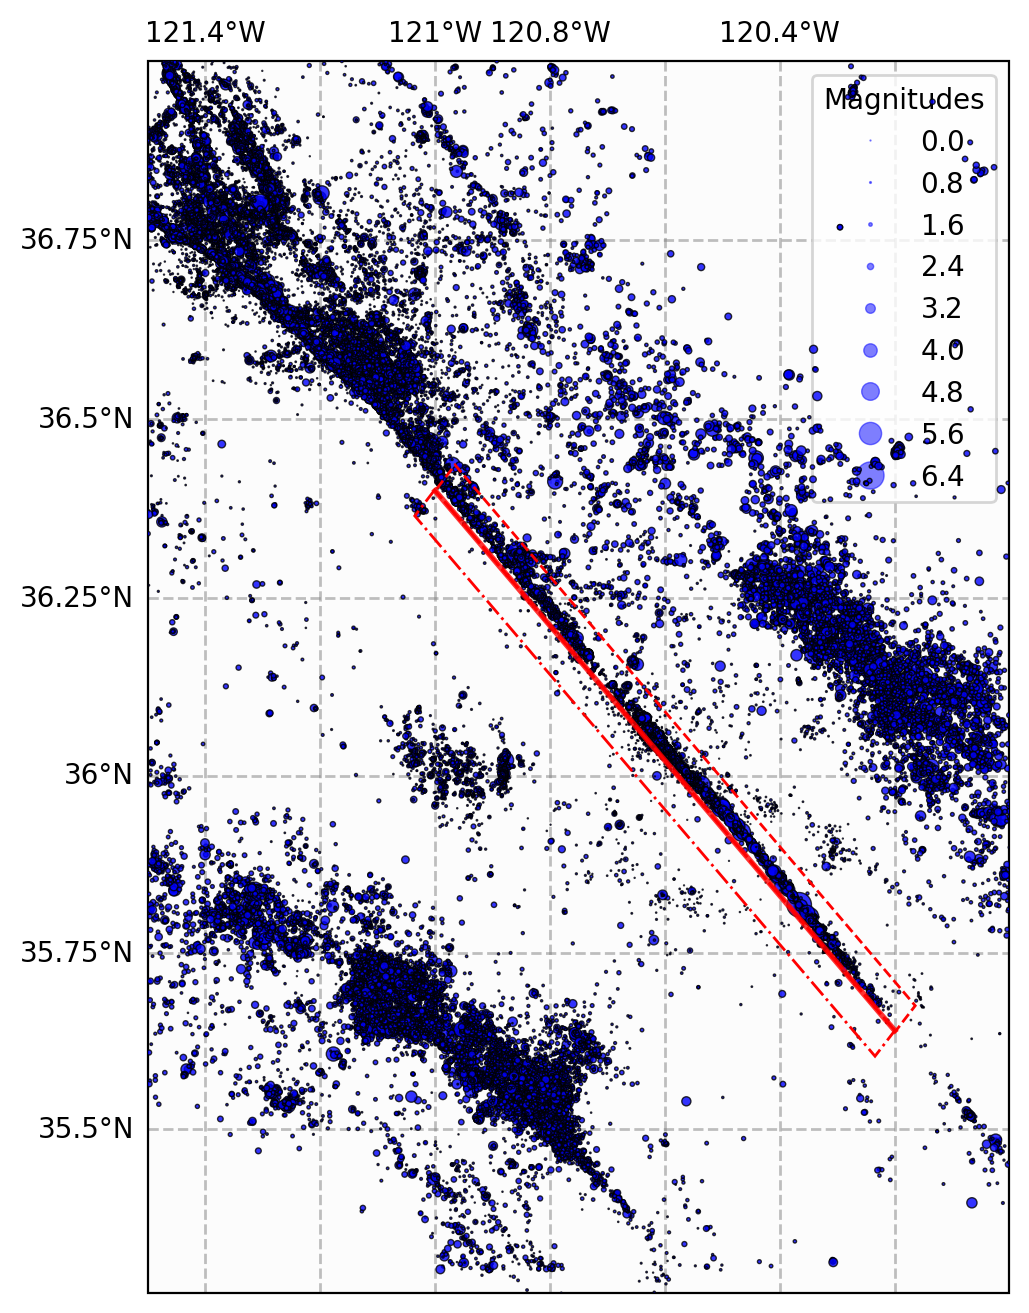

In [4]:
fig = plt.figure(figsize=(8, 8), linewidth=1)    
ax = plot_in_space(df, dot_smallest=0.1,dot_largest=100,dot_interpolation_power=3, include_map=True)

# plot a red line from $P_1 = 121W, 35.64^N) and $P_2 = 120.2W, 36.4N
ll_proj = ccrs.PlateCarree()  # CRS for raw long/lat
exts = [
        min(df["longitude"]),
        max(df["longitude"]),
        min(df["latitude"]),
        max(df["latitude"]),
]
ax.set_extent(exts, crs=ll_proj)


ax.plot([-120.2, -121], [35.64, 36.4],
        color="red",
        zorder=1000,
        transform=ccrs.PlateCarree(),
        linewidth=2,
        alpha=0.8,
    )

# Define the two points
lon1, lat1 = -120.2, 35.64  # point 1
lon2, lat2 = -121, 36.4  # point 2

# Calculate the angle between the two points
angle = np.degrees(np.arctan2(lat2 - lat1, lon2 - lon1))

# Define the width of the box
llll = 1.105
wwww = 0.05

# Create a rectangle
rectangle = mpatches.Rectangle((lon1, lat1), llll, wwww, angle=angle, fill=None, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), linestyle='-.',lw=1, zorder=1000)
# Add the rectangle to the plot
ax.add_patch(rectangle)

rectangle = mpatches.Rectangle((lon2, lat2), llll, wwww, angle=180+angle, fill=None,edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), linestyle='--',lw=1, zorder=1000)
# Add the rectangle to the plot
ax.add_patch(rectangle)

# get current figure
fig = plt.gcf()
print(fig.get_size_inches())  # Print the size of the figure

# 3: cut out Parkfield section

In [5]:
# cross-section
p1 = np.array([36.40, -121.00, 0]) # point where cross-cut begins
p2 = np.array([35.64,-120.20, 0]) # point where cross-cut ends
depth = 20  # in km
width = 10  # width of the section in km
delta = 1   # resolution of grid that is plotted on


In [6]:
x_vor=[];
y_vor=[];
z_vor=[];

mags = np.array(df['magnitude'])

# bin mags
delta_m = 0.01
mags = bin_to_precision(mags, delta_m)

lats = np.array(df['latitude'])
lons = np.array(df['longitude'])
depths = np.array(df['depth'])
time = np.array(df['time'])

#transform to cartesian coordinates, to that p1 is on origin, p2 is on y
# axis and the fault plane is the x-z plane
cart_coords, cart_p2 = transform_and_rotate(p1, p2, lats, lons, depths)

# cut data to only the one in the section
length = np.linalg.norm(cart_p2)
cut_coords, idx1 = cut_section(cart_coords, length, width, depth)
cut_mags = mags[idx1]
cut_times = time[idx1]
cut_depths = depths[idx1]

# oder data in time
idx2 = np.argsort(cut_times)
cut_mags = cut_mags[idx2]
cut_times = cut_times[idx2]
cut_depths = cut_depths[idx2]
cut_coords =cut_coords[:,idx2]

depth 20 -18.450850476287314


# 4: Cut out magnitudes below completeness

In [8]:
mc = 1.3
idx = cut_mags >= mc

cut_mags = cut_mags[idx]
cut_times = cut_times[idx]
cut_depths = cut_depths[idx]
cut_coords = cut_coords[:,idx]

delta_m = 0.01
cut_mags = bin_to_precision(cut_mags, delta_m)


df_PF = pd.DataFrame()
df_PF['magnitude'] = cut_mags
df_PF['time'] = cut_times
df_PF['depth'] = cut_depths
df_PF['x'] = cut_coords[0]
df_PF['y'] = cut_coords[1]
df_PF['z'] = cut_coords[2]

# 5: Estimate the 2D MAC and plot

In [9]:
def get_MAC_vs_npoints(
      cut_coords,
      cut_mags,
      delta_m,
      mc,
      cut_times,
      length,
      depth,
      n_points,
      n=200,
      delta=1,
      min_num=20,
      b_method="positive", 
      scaling_factor=1):
      
      # create 2D grid
      x_vec = np.arange(delta, length, delta)
      z_vec = - np.arange(0, depth, delta)
      grid = np.array(list(itertools.product(x_vec, z_vec)))
      grid = grid.T

      # make EQ coordinates 2 dimensional
      coords_2d = [cut_coords[0, :], cut_coords[2, :]]
      coords_2d = np.array(coords_2d)

      # estimate MAC for different number of points
      mac = np.zeros(len(n_points))
      mu_mac = np.zeros(len(n_points))
      std_mac = np.zeros(len(n_points))
      b_average= []
      mac_a = np.zeros(len(n_points))
      mu_mac_a = np.zeros(len(n_points))
      std_mac_a = np.zeros(len(n_points))
      a_average = []
      limits=[[0,length], [-depth,2]]
      for ii, n_point in enumerate(tqdm(n_points, desc="Processing")):
         (mac[ii], mu_mac[ii], std_mac[ii], b_average_loop,
          mac_a[ii], mu_mac_a[ii], std_mac_a[ii], a_average_loop
         ) = mac_d_dimensions(coords_2d, cut_mags, delta_m, mc, cut_times, limits, n_points = n_point, n_realizations=n, eval_coords=grid,min_num=min_num, b_method=b_method, scaling_factor=scaling_factor, include_a=True)
         b_average.append(b_average_loop)
         a_average.append(a_average_loop)

      return mac, mu_mac, std_mac, b_average, mac_a, mu_mac_a, std_mac_a, a_average, grid

In [10]:
n_points = np.array([300])
limits=[[0,length], [-depth,2]]

time_delta = (max(cut_times)- min(cut_times))
years = time_delta / np.timedelta64(1, 'D') / 365.25
scaling_factor = years
for jj in range(2):
    scaling_factor *= (limits[jj][1] - limits[jj][0])

mac, mu_mac, std_mac, b_average, mac_a, mu_mac_a, std_mac_a, a_average, grid = get_MAC_vs_npoints(cut_coords, cut_mags, 0.01, mc, cut_times, length, depth, n_points, n=100, scaling_factor=scaling_factor)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:899: RuntimeWarning: invalid value encountered in scalar divide
  np.log(10) * b**2 * np.std(magnitudes) / np.sqrt(len(magnitudes) - 1)
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/numpy/_core/_methods.p

<Axes: >

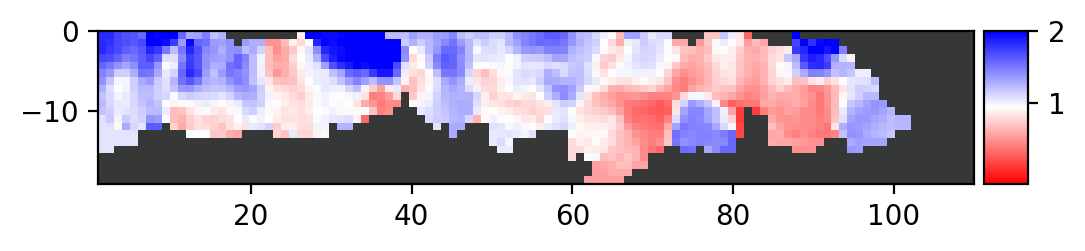

In [11]:
plot_averagemap(b_average[0], grid, 0.3, 2, 0.94, cmap=cm.bwr_r)

<Axes: >

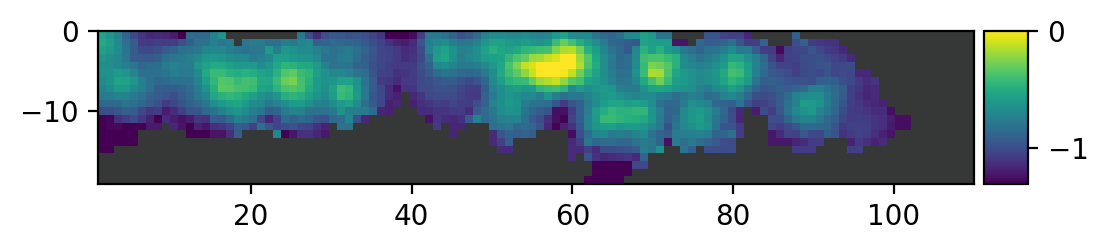

In [12]:
plot_averagemap(a_average[0], grid,  -1.3, 0)

<Axes: >

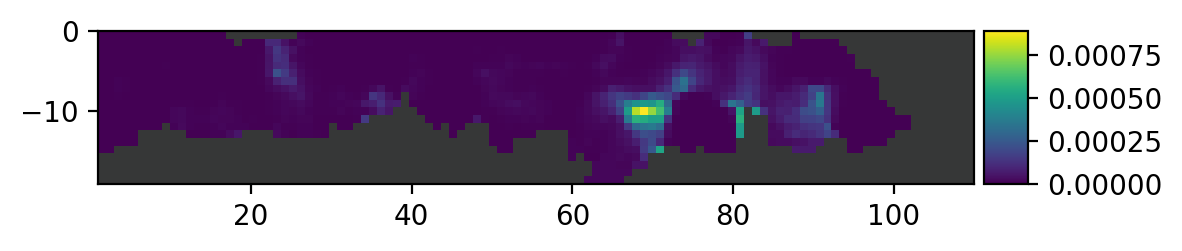

In [13]:
p = probability_m(a_average[0], b_average[0], m = 6.0, m_ref=1.3)
plot_averagemap(p, grid)

In [15]:
n_points = np.array([20, 30, 50,  90, 130, 170, 210, 250, 290, 330, 370, 410, 450, 500,600, 800, 1000])

mac, mu_mac, std_mac, b_average, mac_a, mu_mac_a, std_mac_a, a_average, grid= get_MAC_vs_npoints(cut_coords, cut_mags, delta_m, mc, cut_times, length, depth, n_points, n=1000,scaling_factor=scaling_factor)

Processing:  41%|████      | 7/17 [04:09<08:13, 49.30s/it]/Users/aron/polybox/Projects/b_significant/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:165: RuntimeWarning: invalid value encountered in log
  beta = 1 / delta_m * np.log(p)
Processing: 100%|██████████| 17/17 [39:31<00:00, 139.51s/it]


In [22]:
np.argmax(mac)

np.int64(12)

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_18090/1353102674.py:23: SyntaxWarning: invalid escape sequence '\m'
  axs.plot(A_average, -1/n_points, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


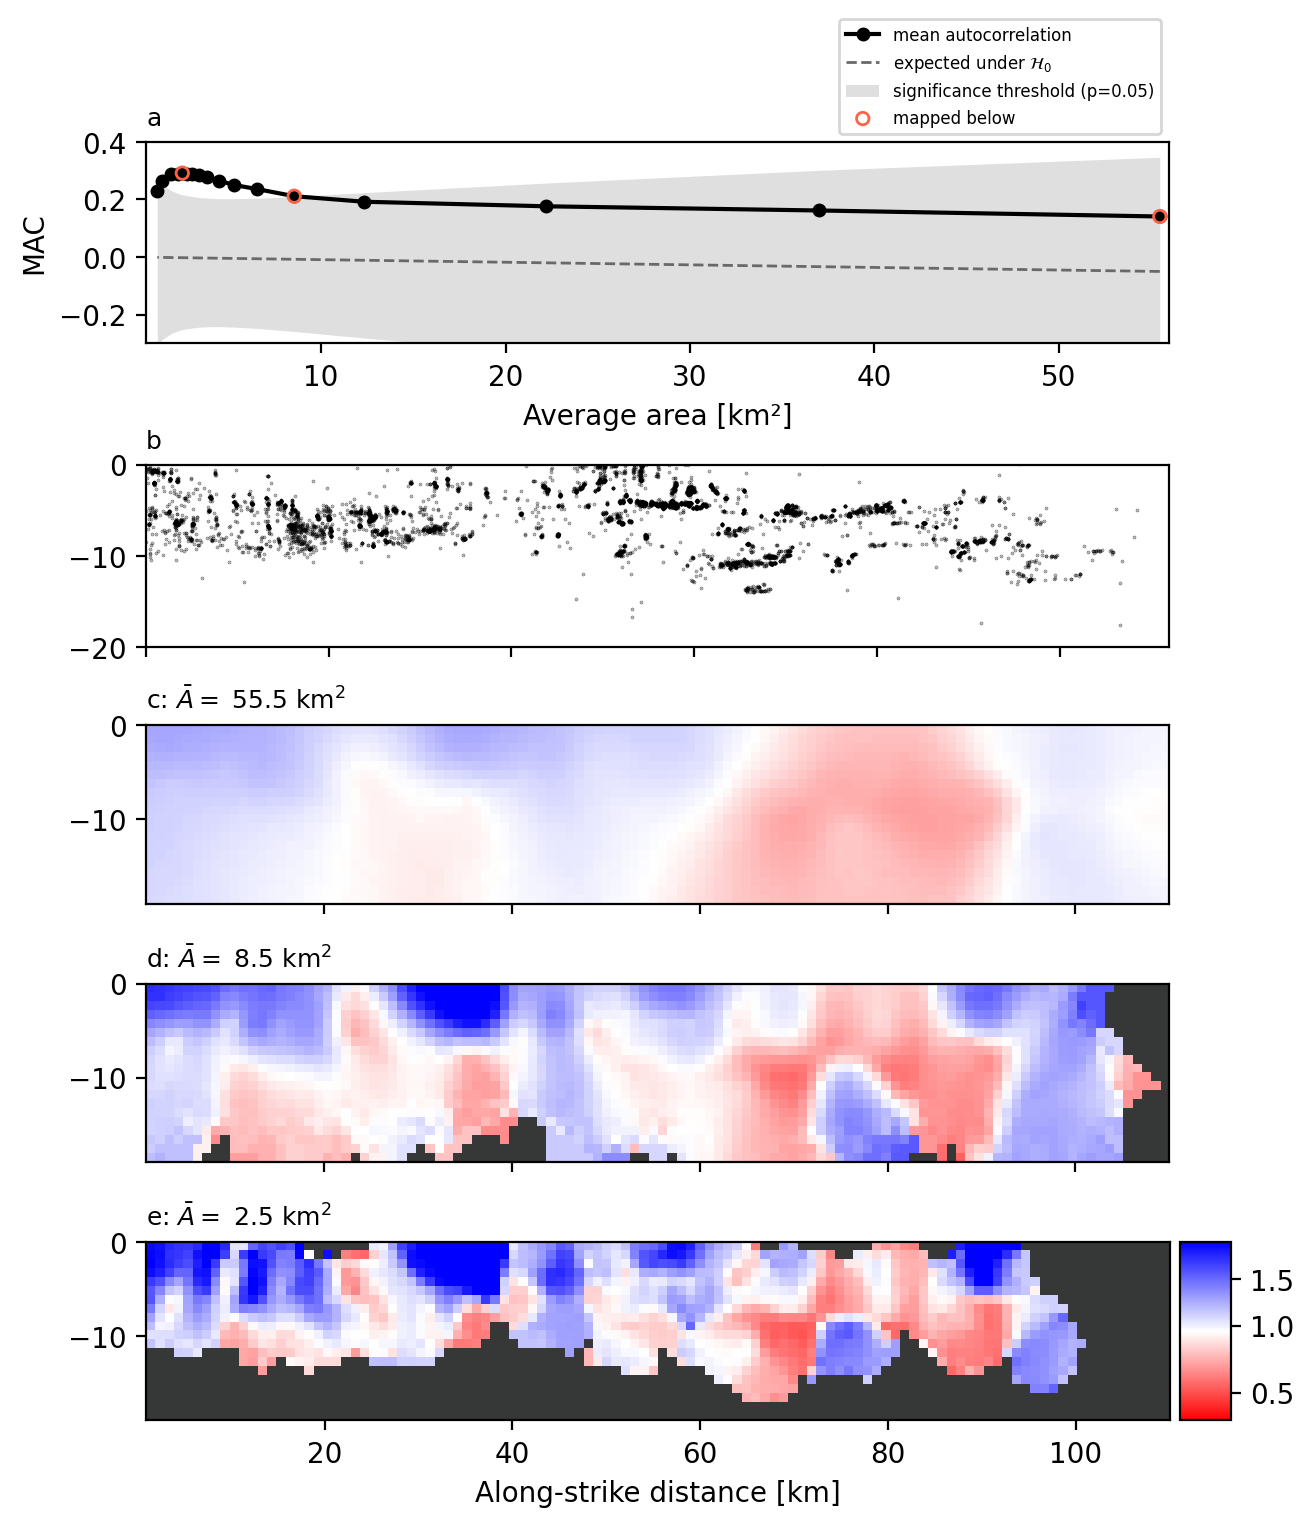

In [24]:

ig = plt.figure(figsize=(7, 8.5))  # Set the figure size
gs = GridSpec(
    nrows=14,
    ncols=2,
    height_ratios=[1.1,0.3,0.05,1,0.05, 0.05,1,0.05,0.05,1,0.05,0.05,1,0.05],
    width_ratios=[1, 0.01],
    hspace=0.25,
    wspace=0.1,

)

# ==============================================================================
# 1
# ==============================================================================
axs = plt.subplot(gs[0, 0])

# convert points to area
A_total = length*width
A_average = A_total/n_points
mac = np.array(mac)

axs.plot(A_average, mac, color='k', label='mean autocorrelation', marker='o', markersize=4)    
axs.plot(A_average, -1/n_points, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
axs.fill_between(A_average, mu_mac - 1.96 * std_mac, mu_mac + 1.96 * std_mac, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

chosen_points = [0,4,12]
axs.scatter(A_average[chosen_points], mac[chosen_points], label='mapped below', s=20, zorder=100, facecolor='none', edgecolor='tomato')

axs.set_title('a', fontsize=9, loc='left')
axs.set_xlim([0.5, 56])
axs.set_ylim([-0.3, 0.4])
axs.set_yticks([-0.2, 0, 0.2, 0.4])  # Set the y-ticks


axs.legend(bbox_to_anchor=(1, 1), loc="lower right", fontsize=6)
axs.set_ylabel('MAC')
axs.set_xlabel('Average area [km²]')

# ==============================================================================
# 2 -5
# ==============================================================================
axs = plt.subplot(gs[2:5, 0])
axs.scatter(cut_coords[0,:], cut_coords[2,:], s=0.1, color='k', alpha=0.5)
# set limits
axs.set_xlim([0,112])
axs.set_ylim([-20,0])
axs.set_aspect('equal', adjustable='box')
axs.set_xticklabels([])
axs.set_title('b', fontsize=9, loc='left')

# plot the average b-value map
axs = plt.subplot(gs[5:8, 0])
axs.set_title('c: '+r'$\bar A =$ {:.1f}'.format(A_average[chosen_points[0]]) +' km$^2$', fontsize=9, loc='left')
plot_averagemap(b_average[chosen_points[0]], grid, 0.3, 1.9, 0.94, cmap=cm.bwr_r, ax=axs, show_colorbar=False)
axs.set_xticklabels([])

# plot the average b-value map
axs = plt.subplot(gs[8:11, 0])
axs.set_title('d: '+r'$\bar A =$ {:.1f}'.format(A_average[chosen_points[1]]) +' km$^2$', fontsize=9, loc='left')
plot_averagemap(b_average[chosen_points[1]], grid, 0.3, 1.9, 0.94, cmap=cm.bwr_r, ax=axs, show_colorbar=False)

axs.set_xticklabels([])

# plot the average b-value map
axs = plt.subplot(gs[11:14, 0:2])
axs.set_title('e: '+r'$\bar A =$ {:.1f}'.format(A_average[chosen_points[2]]) +' km$^2$', fontsize=9, loc='left')
plot_averagemap(b_average[chosen_points[2]], grid, 0.3, 1.9, 0.94, cmap=cm.bwr_r, ax=axs)
axs.set_xlabel('Along-strike distance [km]')

# make y label in the middel of the subplots
fig.text(0.028, 0.37, 'Depth [km]', rotation='vertical')

plt.savefig("2D_Parkfield.jpg") #save as jpg

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_18090/4255391033.py:23: SyntaxWarning: invalid escape sequence '\m'
  axs.plot(A_average, -1/n_points, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


Text(0.028, 0.37, 'Depth [km]')

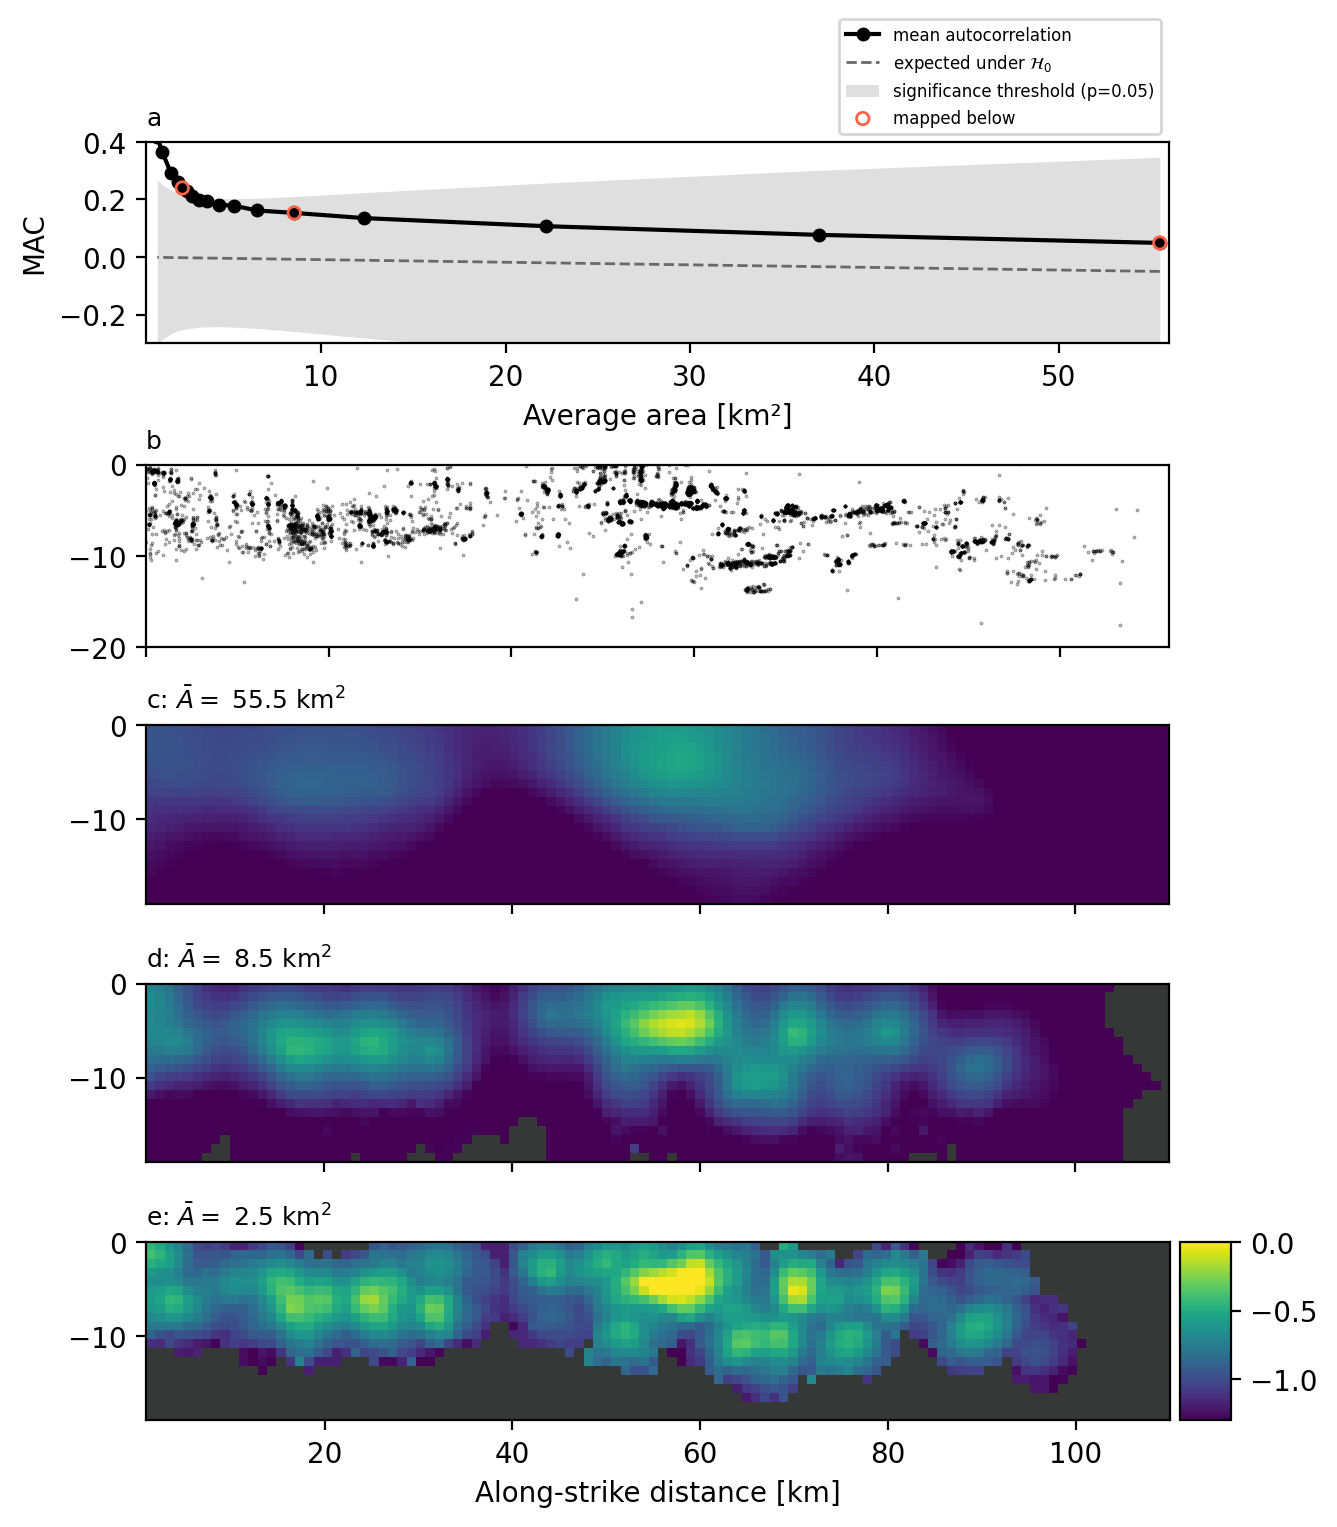

In [23]:

ig = plt.figure(figsize=(7, 8.5))  # Set the figure size
gs = GridSpec(
    nrows=14,
    ncols=2,
    height_ratios=[1.1,0.3,0.05,1,0.05, 0.05,1,0.05,0.05,1,0.05,0.05,1,0.05],
    width_ratios=[1, 0.01],
    hspace=0.25,
    wspace=0.1,

)

# ==============================================================================
# 1
# ==============================================================================
axs = plt.subplot(gs[0, 0])

# convert points to area
A_total = length*width
A_average = A_total/n_points
mac_a = np.array(mac_a)

axs.plot(A_average, mac_a, color='k', label='mean autocorrelation', marker='o', markersize=4)    
axs.plot(A_average, -1/n_points, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
axs.fill_between(A_average, mu_mac - 1.96 * std_mac, mu_mac + 1.96 * std_mac, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

chosen_points = [0,4,12]
axs.scatter(A_average[chosen_points], mac_a[chosen_points], label='mapped below', s=20, zorder=100, facecolor='none', edgecolor='tomato')

axs.set_title('a', fontsize=9, loc='left')
axs.set_xlim([0.5, 56])
axs.set_ylim([-0.3, 0.4])
axs.set_yticks([-0.2, 0, 0.2, 0.4])  # Set the y-ticks


axs.legend(bbox_to_anchor=(1, 1), loc="lower right", fontsize=6)
axs.set_ylabel('MAC')
axs.set_xlabel('Average area [km²]')

# ==============================================================================
# 2 -5
# ==============================================================================
axs = plt.subplot(gs[2:5, 0])
axs.scatter(cut_coords[0,:], cut_coords[2,:], s=0.1, color='k', alpha=0.5)
# set limits
axs.set_xlim([0,112])
axs.set_ylim([-20,0])
axs.set_aspect('equal', adjustable='box')
axs.set_xticklabels([])
axs.set_title('b', fontsize=9, loc='left')

# plot the average b-value map
axs = plt.subplot(gs[5:8, 0])
axs.set_title('c: '+r'$\bar A =$ {:.1f}'.format(A_average[chosen_points[0]]) +' km$^2$', fontsize=9, loc='left')
plot_averagemap(a_average[chosen_points[0]], grid, -1.3, 0, ax=axs, show_colorbar=False)
axs.set_xticklabels([])

# plot the average b-value map
axs = plt.subplot(gs[8:11, 0])
axs.set_title('d: '+r'$\bar A =$ {:.1f}'.format(A_average[chosen_points[1]]) +' km$^2$', fontsize=9, loc='left')
plot_averagemap(a_average[chosen_points[1]], grid, -1.3, 0, ax=axs, show_colorbar=False)

axs.set_xticklabels([])

# plot the average b-value map
axs = plt.subplot(gs[11:14, 0:2])
axs.set_title('e: '+r'$\bar A =$ {:.1f}'.format(A_average[chosen_points[2]]) +' km$^2$', fontsize=9, loc='left')
plot_averagemap(a_average[chosen_points[2]], grid,  -1.3, 0, ax=axs)
axs.set_xlabel('Along-strike distance [km]')

# make y label in the middel of the subplots
fig.text(0.028, 0.37, 'Depth [km]', rotation='vertical')